# Forecast-Customer-Data





###Importing important modules and downloading the data file.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import itertools
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import nltk
nltk.download('punkt')
%matplotlib inline
plt.style.use('fivethirtyeight')
import urllib.request
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx'
urllib.request.urlretrieve(url, 'data.xlsx')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


('data.xlsx', <http.client.HTTPMessage at 0x7fbcff151a20>)

In [ ]:
data = pd.read_excel('data.xlsx', dtype={'StockCode':str})
data.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom


In [ ]:
data.shape

(541909, 8)

###Data Preprocessing

####Null Value check and removal

In [ ]:
df = pd.DataFrame(data=data.isnull().sum()).T.rename(index={0:'Null values'})
df = df.append(pd.DataFrame(data=data.isnull().sum()/data.shape[0] * 100).T.rename(index={0:'% Null values'}))
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
Null values,0.0,0.0,1454.000000,0.0,0.0,0.0,135080.000000,0.0
% Null values,0.0,0.0,0.268311,0.0,0.0,0.0,24.926694,0.0


In [ ]:
data.dropna(axis=0, subset = ['CustomerID'], inplace=True)
df = pd.DataFrame(data=data.isnull().sum()).T.rename(index={0:'Null values'})
df = df.append(pd.DataFrame(data=data.isnull().sum()/data.shape[0] * 100).T.rename(index={0:'% Null values'}))
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
Null values,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
% Null values,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


####Duplicate value check and removal

In [ ]:
data.duplicated().sum()

5225

In [ ]:
data.drop_duplicates(inplace=True)
data.duplicated().sum()

0

###Data Analysis

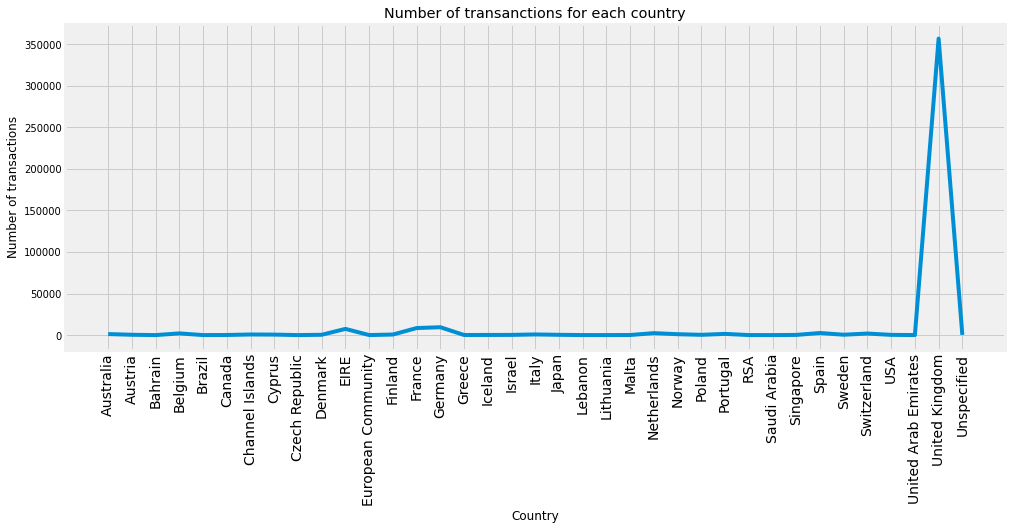

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(list(data.groupby(['Country']).groups.keys()), data.groupby(['Country'])['CustomerID'].count())
plt.xticks(rotation = 90, fontsize = 14)
plt.title("Number of transanctions for each country")
plt.ylabel("Number of transactions")
plt.xlabel("Country")
plt.show()

In [ ]:
df = pd.DataFrame(data = data.groupby(['Country'])['InvoiceNo'].nunique(), index=data.groupby(['Country']).groups.keys()).T
df

,Australia,Austria,Bahrain,Belgium,Brazil,Canada,Channel Islands,Cyprus,Czech Republic,Denmark,EIRE,European Community,Finland,France,Germany,Greece,Iceland,Israel,Italy,Japan,Lebanon,Lithuania,Malta,Netherlands,Norway,Poland,Portugal,RSA,Saudi Arabia,Singapore,Spain,Sweden,Switzerland,USA,United Arab Emirates,United Kingdom,Unspecified
InvoiceNo,69,19,2,119,1,6,33,20,5,21,319,5,48,458,603,6,7,6,55,28,1,4,10,101,40,24,70,1,2,10,105,46,71,7,3,19857,8


>Inferences
1. UK has done most of the transanctions. (19857)
2. Least amount of transanctions were made by countries like Brazil, RSA etc. (only 1)

In [ ]:
pd.DataFrame({'products':len(data['StockCode'].value_counts()),
              'transanctions':len(data['InvoiceNo'].value_counts()),
              'Customers':len(data['CustomerID'].value_counts())},
             index = ['Quantity'])

,products,transanctions,Customers
Quantity,3684,22190,4372


> There are around 22000 transanctions but only 4000 customers with 3500 products. This maybe because some orders were placed then cancelled or the customers bought items multiple times or multiple items were bought in a single transanction.

>Therefore checking for number of items bought in a transaction

In [ ]:
df = data.groupby(['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
df = df.rename(columns = {'InvoiceDate':'Number of products'})
df[:10].sort_values('CustomerID')

,CustomerID,InvoiceNo,Number of products
0,12346.0,541431,1
1,12346.0,C541433,1
2,12347.0,537626,31
3,12347.0,542237,29
4,12347.0,549222,24
5,12347.0,556201,18
6,12347.0,562032,22
7,12347.0,573511,47
8,12347.0,581180,11
9,12348.0,539318,17


>There are some orders which were cancelled they are marked with 'C' in the beginning.

####Counting cancelled orders

In [ ]:
df['orders cancelled'] = df['InvoiceNo'].apply(lambda x: int('C' in str(x)))
df.head()

,CustomerID,InvoiceNo,Number of products,orders cancelled
0,12346.0,541431,1,0
1,12346.0,C541433,1,1
2,12347.0,537626,31,0
3,12347.0,542237,29,0
4,12347.0,549222,24,0


In [ ]:
print("Number of orders cancelled {}/{} ({:.3f}%)".format(df['orders cancelled'].sum(), df.shape[0], df['orders cancelled'].sum()/ df.shape[0] * 100))

Number of orders cancelled 3654/22190 (16.467%)


####Managing cancelled orders

In [ ]:
data.sort_values('CustomerID')[:5]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346.0,United Kingdom
286623,562032,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2011-08-02 08:48:00,4.25,12347.0,Iceland
72260,542237,84991,60 TEATIME FAIRY CAKE CASES,24,2011-01-26 14:30:00,0.55,12347.0,Iceland
14943,537626,22772,PINK DRAWER KNOB ACRYLIC EDWARDIAN,12,2010-12-07 14:57:00,1.25,12347.0,Iceland


>For every order that has to be cancelled a new transanction is started with different invoice no., with same negative quantity and every other description. We can use this to remove the cancelled orders.



####Discounted items

In [ ]:
df = data[data['Description'] == 'Discount']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
9038,C537164,D,Discount,-1,2010-12-05 13:21:00,29.29,14527.0,United Kingdom
14498,C537597,D,Discount,-1,2010-12-07 12:34:00,281.00,15498.0,United Kingdom
19392,C537857,D,Discount,-1,2010-12-08 16:00:00,267.12,17340.0,United Kingdom
31134,C538897,D,Discount,-1,2010-12-15 09:14:00,5.76,16422.0,United Kingdom


>Looks like discounted products are generally cancelled

####Check for ordered and cancelled products

In [ ]:
df = data[(data['Quantity']<0) & (data['Description']!='Discount')][['CustomerID','Quantity','StockCode','Description','UnitPrice']]
df.head()

,CustomerID,Quantity,StockCode,Description,UnitPrice
154,15311.0,-1,35004C,SET OF 3 COLOURED FLYING DUCKS,4.65
235,17548.0,-12,22556,PLASTERS IN TIN CIRCUS PARADE,1.65
236,17548.0,-24,21984,PACK OF 12 PINK PAISLEY TISSUES,0.29
237,17548.0,-24,21983,PACK OF 12 BLUE PAISLEY TISSUES,0.29
238,17548.0,-24,21980,PACK OF 12 RED RETROSPOT TISSUES,0.29


In [ ]:
for ind, row in df.iterrows():
    if data[(data['CustomerID'] == row[0]) & (data['Quantity'] == -row[1]) & (data['Description'] == row[2])].shape[0] == 0:
        print(ind, df.loc[ind])
        print("There are some transanctions for which ordering does not exist")
        break

154 CustomerID                               15311
Quantity                                    -1
StockCode                               35004C
Description    SET OF 3 COLOURED  FLYING DUCKS
UnitPrice                                 4.65
Name: 154, dtype: object
There are some transanctions for which ordering does not exist


>Reasons for non existant ordered and cancelled pairs could be because some orders were made before the date the dataset is given from or that some orders were cancelled with exactly same counterpart or some are just errors maybe.

####Removing cancelled entries

In [ ]:
clean_df = data.copy(deep=True)
clean_df['QuatityCancelled'] = 0
to_remove = []; doubtfull = []

for index, rows in data.iterrows():
    if(rows['Quantity'] > 0)or(rows['Description']=='Discount'):continue
    df_test = data[(data['CustomerID']==rows['CustomerID'])&(data['StockCode']==rows['StockCode'])&
                   (data['InvoiceDate']<rows['InvoiceDate'])&(data['Quantity']>0)].copy()
    
    # Order cancelled without counterpart, these are doubtful as they maybe errors or maybe orders were placed before data given
    if(df_test.shape[0] == 0):
        doubtfull.append(index)
    
    # Cancellation with single counterpart
    elif(df_test.shape[0] == 1):
        index_order = df_test.index[0]
        clean_df.loc[index_order, 'QuantityCancelled'] = -rows['Quantity']
        to_remove.append(ind)
        
    # Various counterpart exists for orders
    elif(df_test.shape[0] > 1):
        df_test.sort_index(axis = 0, ascending=False, inplace=True)
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -rows['Quantity']:continue
            clean_df.loc[ind, 'QuantityCancelled'] = -rows['Quantity']
            to_remove.append(index)
            break

In [ ]:
print("Entry to remove {}".format(len(to_remove)))
print("Doubtfull Entry {}".format(len(doubtfull)))

Entry to remove 7521
Doubtfull Entry 1226


In [ ]:
clean_df.drop(to_remove, axis=0, inplace=True)
clean_df.drop(doubtfull, axis=0, inplace=True)

####Discounted products in StockCode

In [ ]:
codes = clean_df[clean_df['StockCode'].str.contains('^[a-zA-Z]+', regex = True)]['StockCode'].unique()
codes

array(['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT'],
      dtype=object)

In [ ]:
for code in codes:
    print("{:<15} -> {:<30}".format(code, clean_df[clean_df['StockCode'] == code]['Description'].values[0]))

POST            -> POSTAGE                       
D               -> Discount                      
C2              -> CARRIAGE                      
M               -> Manual                        
BANK CHARGES    -> Bank Charges                  
PADS            -> PADS TO MATCH ALL CUSHIONS    
DOT             -> DOTCOM POSTAGE                


In [ ]:
clean_df['QuantityCancelled'] = np.nan_to_num(clean_df['QuantityCancelled'])
clean_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuatityCancelled,QuantityCancelled
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0,0.0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,0.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0,0.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,0.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,0.0


>Some invoice numbers like 536365 has duplicate enries. The user might have purchased different items and each item has given a row as shown. We will merge these so we can add the totalprice feature for each row.

####Getting total data

In [ ]:
clean_df['TotalPrice'] = clean_df['UnitPrice'] * (clean_df['Quantity'] - clean_df['QuantityCancelled'])
clean_df.sort_values('CustomerID')[:5]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuatityCancelled,QuantityCancelled,TotalPrice
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346.0,United Kingdom,0,0.0,-77183.6
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,0,74215.0,0.0
14938,537626,85116,BLACK CANDELABRA T-LIGHT HOLDER,12,2010-12-07 14:57:00,2.10,12347.0,Iceland,0,0.0,25.2
428966,573511,22423,REGENCY CAKESTAND 3 TIER,6,2011-10-31 12:25:00,12.75,12347.0,Iceland,0,0.0,76.5
428967,573511,23173,REGENCY TEAPOT ROSES,2,2011-10-31 12:25:00,9.95,12347.0,Iceland,0,0.0,19.9


>Summing individual orders and grouping them based on invoice number to remove the problem of duplicate rows for same order


In [ ]:
temp = clean_df.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
net_price = temp.rename(columns = {'TotalPrice': 'Net Price'})

clean_df['InvoiceDate_int'] = clean_df['InvoiceDate'].astype('int64')
temp = clean_df.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
clean_df.drop('InvoiceDate_int', axis = 1, inplace=True)
net_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])

net_price = net_price[net_price['Net Price'] > 0]
net_price.sort_values('CustomerID')[:6]

,CustomerID,InvoiceNo,Net Price,InvoiceDate
2,12347.0,537626,711.79,2010-12-07 14:57:00.000001024
3,12347.0,542237,475.39,2011-01-26 14:29:59.999999744
4,12347.0,549222,636.25,2011-04-07 10:42:59.999999232
5,12347.0,556201,382.52,2011-06-09 13:01:00.000000256
6,12347.0,562032,584.91,2011-08-02 08:48:00.000000000
7,12347.0,573511,1294.32,2011-10-31 12:25:00.000001280


####Purchases

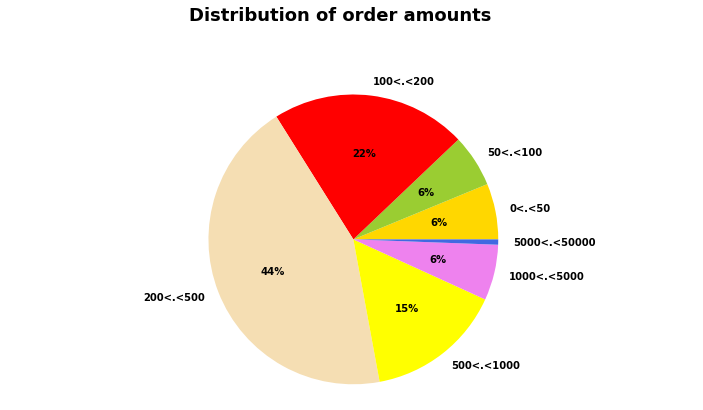

In [ ]:
price_range = [0, 50, 100, 200, 500, 1000, 5000, 50000]
count_price = []
for i,price in enumerate(price_range):
    if i==0:continue
    val = net_price[(net_price['Net Price'] < price)&
                       (net_price['Net Price'] > price_range[i-1])]['Net Price'].count()
    count_price.append(val)
    
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
colors = ['gold' ,'yellowgreen', 'red', 'wheat', 'yellow', 'violet', 'royalblue', 'firebrick']
labels = ["{}<.<{}".format(price_range[i-1], s) for i,s in enumerate(price_range) if i != 0]
sizes = count_price
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels = labels, colors = colors,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow = False, startangle = 0)
ax.axis('equal')
f.text(0.5, 1.01, "Distribution of order amounts", ha = 'center', fontsize = 18)
plt.show()

####Product analysis



In [ ]:
is_noun = lambda pos:pos[:2] == 'NN'
nltk.download('averaged_perceptron_tagger')
def keywords(dataframe, colonn = 'Description'):
    stemmer = nltk.stem.SnowballStemmer("english")
    keywords_roots = dict()
    keywords_select = dict()
    category_keys = []
    count_keywords = dict()
    icount = 0
    
    for s in dataframe[colonn]:
        if pd.isnull(s): continue
        lines = s.lower()
        tokenized = nltk.word_tokenize(lines)
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)]
        
        for t in nouns:
            t = t.lower() ; racine = stemmer.stem(t)
            if racine in keywords_roots:
                keywords_roots[racine].add(t)
                count_keywords[racine] += 1
            else:
                keywords_roots[racine] = {t}
                count_keywords[racine] = 1
        
    
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k ; min_length = len(k)
            
            category_keys.append(clef)
            keywords_select[s] = clef
        
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
            
    print("Number of keywords in the variable '{}': {}".format(colonn, len(category_keys)))
    return category_keys, keywords_roots, keywords_select, count_keywords

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
df_products = pd.DataFrame(data['Description'].unique()).rename(columns = {0:"Description"})

In [ ]:
keywords, keywords_roots, keywords_select, count_keywords = keywords(df_products)

Number of keywords in the variable 'Description': 1483


>Keywords vs Frequency

In [ ]:
list_products = []
for k, v in count_keywords.items():
    word = keywords_select[k]
    list_products.append([word, v])

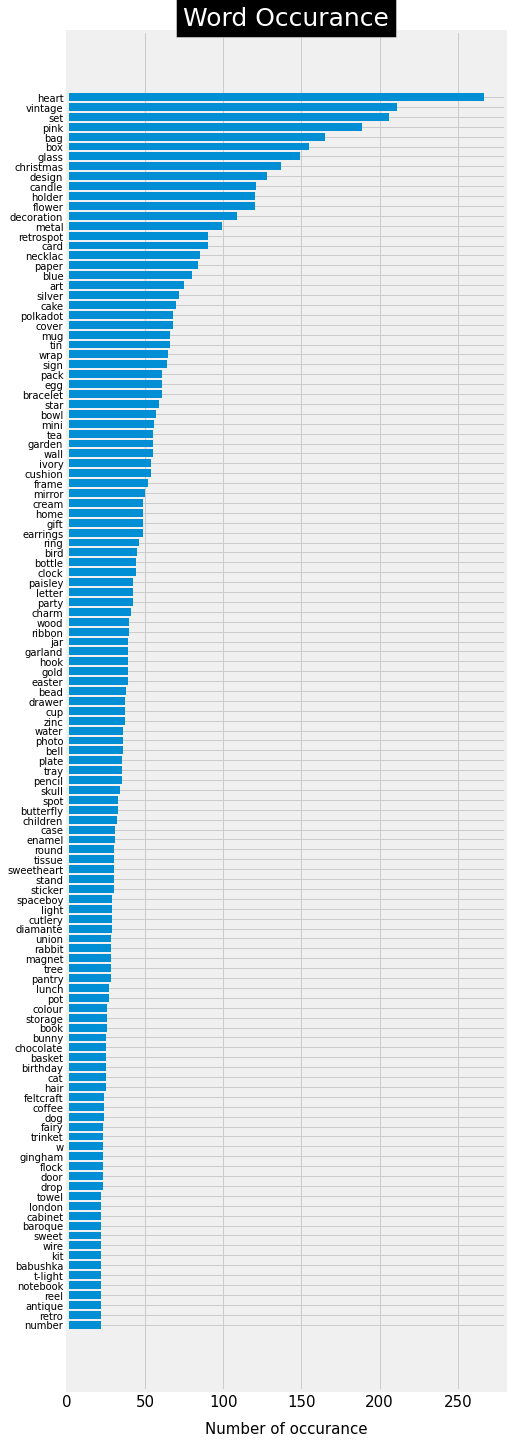

In [ ]:
list_ = sorted(list_products, key = lambda x:x[1], reverse=True)

plt.rc('font', weight='normal')
fig, ax = plt.subplots(figsize=(7, 25))
y_axis = [i[1] for i in list_[:125]]
x_axis = [k for k,i in enumerate(list_[:125])]
x_label = [i[0] for i in list_[:125]]
plt.xticks(fontsize=15)
plt.yticks(fontsize=10)
plt.yticks(x_axis, x_label)
plt.xlabel("Number of occurance", fontsize = 15, labelpad = 12)
ax.barh(x_axis, y_axis, align='center')
ax = plt.gca()
ax.invert_yaxis()

plt.title("Word Occurance", bbox={'facecolor':'k', 'pad':7}, color='w', fontsize = 25)
plt.show()

>Important words

In [ ]:
list_products = []
for k, v in count_keywords.items():
    word = keywords_select[k]
    if word in ['pink', 'blue', 'tag', 'green', 'orange']: continue
    if len(word)<3 or v<13: continue
    list_products.append([word, v])
    
list_products.sort(key = lambda x:x[1], reverse=True)
print("Number of preserved words : ", len(list_products))

Number of preserved words :  193


##### Descrining products in terms of words in the description :
1. Only preserved words will be used, just like Binary Bag of Words.
2. Then we will convert this into a product matrix with products as rows and different words as columns. A cell contains a 1 if a particular product has that word in its description otherwise 0.
3. This matrix is used to categorize the products.
4. A mean price feature will be added so that the groups are balanced.

In [ ]:
thres = [0, 1, 2, 3, 5, 10]

lists_products = clean_df['Description'].unique()

# Creating the product and word matrix.
X = pd.DataFrame()
for key, occurence in list_products:
    X.loc[:, key] = list(map(lambda x:int(key.upper() in x), lists_products))
    

label_col = []
for i in range(len(thres)):
    if i == len(thres) - 1:
        col = '.>{}'.format(thres[i])
    else:
        col = '{}<.<{}'.format(thres[i], thres[i+1])
        
    label_col.append(col)
    X.loc[:, col] = 0
    
for i, prod in enumerate(lists_products):
    price = clean_df[clean_df['Description'] == prod]['UnitPrice'].mean()
    j = 0
    
    while price > thres[j]:
        j += 1
        if j == len(thres):
            break
    X.loc[i, label_col[j-1]] = 1

In [ ]:
print("{:<8} {:<20} \n".format('range', 'number of products') + 20*'-')
for i in range(len(thres)):
    if i == len(thres)-1:
        col = '.>{}'.format(thres[i])
    else:
        col = '{}<.<{}'.format(thres[i],thres[i+1])
    print("{:<10}  {:<20}".format(col, X.loc[:, col].sum()))

range    number of products   
--------------------
0<.<1       964                 
1<.<2       1009                
2<.<3       672                 
3<.<5       607                 
5<.<10      472                 
.>10        154                 


###Clustering

In [ ]:
matrix = X.to_numpy()

>Hyperparameter tuning

In [ ]:
for n_clusters in range(3, 10):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init = 30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    sil_avg = silhouette_score(matrix, clusters)
    print("For n_clusters : ", n_clusters, "The average silhouette_score is : ", sil_avg)

For n_clusters :  3 The average silhouette_score is :  0.10167210840027487
For n_clusters :  4 The average silhouette_score is :  0.1268910115747399
For n_clusters :  5 The average silhouette_score is :  0.12110231246892159
For n_clusters :  6 The average silhouette_score is :  0.14522015481011297
For n_clusters :  7 The average silhouette_score is :  0.1497509685805339
For n_clusters :  8 The average silhouette_score is :  0.14944733549305536
For n_clusters :  9 The average silhouette_score is :  0.1383938211385662


>Choosing 5 as number of clusters

In [ ]:
n_clusters = 5
sil_avg = -1
while sil_avg < 0.145:
    kmeans = KMeans(init = 'k-means++', n_clusters = n_clusters, n_init = 30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    sil_avg = silhouette_score(matrix, clusters)
    print("For n_clusters : ", n_clusters, "The average silhouette_score is : ", sil_avg)

For n_clusters :  5 The average silhouette_score is :  0.14754159221079913


>No. of elements in each cluster

In [ ]:
pd.Series(clusters).value_counts()

4    1009
2     964
0     672
3     626
1     607
dtype: int64

####Analysing Clusters

In [ ]:
def graph_silhouette(n_clusters, lim_x, mat_size, sample_silhouette_values, clusters):
    import matplotlib as mpl
    mpl.rc('patch', edgecolor = 'dimgray', linewidth = 1)
    
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(8, 8)
    ax1.set_xlim([lim_x[0], lim_x[1]])
    ax1.set_ylim([0, mat_size + (n_clusters + 1) * 10])
    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhoutte_values = sample_silhouette_values[clusters == i]
        ith_cluster_silhoutte_values.sort()
        size_cluster_i = ith_cluster_silhoutte_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhoutte_values, alpha = 0.8)
        
        ax1.text(-0.03, y_lower + 0.5 * size_cluster_i, str(i), color = 'red', fontweight = 'bold',
                 bbox = dict(facecolor = 'white', edgecolor = 'black', boxstyle = 'round, pad = 0.3'))
        
        y_lower = y_upper + 10

>Plotting the silhouette distances between clusters.

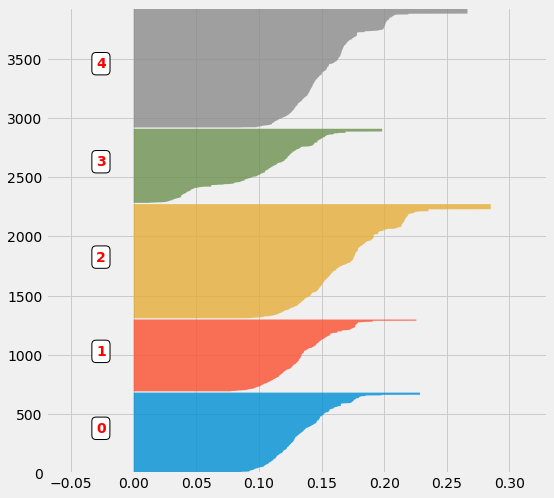

In [ ]:
from sklearn.metrics import silhouette_samples
sample_silhouette_values = silhouette_samples(matrix, clusters)
graph_silhouette(n_clusters, [-0.07, 0.33], len(X), sample_silhouette_values, clusters)

####Wordcloud analysis

In [ ]:
import wordcloud

In [ ]:
liste = pd.DataFrame(lists_products)
liste_words = [word for (word, occurance) in list_products]

occurance = [dict() for _ in range(n_clusters)]

In [ ]:
for i in range(n_clusters):
    liste_cluster = list_.loc[clusters == i]
    for word in liste_words:
        if word in ['art', 'set', 'heart', 'pink', 'blue', 'tag']: continue
        occurance[i][word] = sum(liste_cluster.loc[:, 0].str.contains(word.upper()))

In [ ]:
from random import randint
import random
def random_color_func(word=None, font_size=None, position=None,orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

In [ ]:
def make_wordcloud(liste, increment):
    ax1 = fig.add_subplot(4, 2, increment)
    words = dict()
    trunc_occurances = liste[0:150]
    for s in trunc_occurances:
        words[s[0]] = s[1]
        
    wc = wordcloud.WordCloud(width=1000,height=400, background_color='lightgrey', max_words=1628,relative_scaling=1,
                             color_func = random_color_func, normalize_plurals=False)
    wc.generate_from_frequencies(words)
    ax1.imshow(wc, interpolation="bilinear")
    ax1.axis('off')
    plt.title('cluster n{}'.format(increment-1))

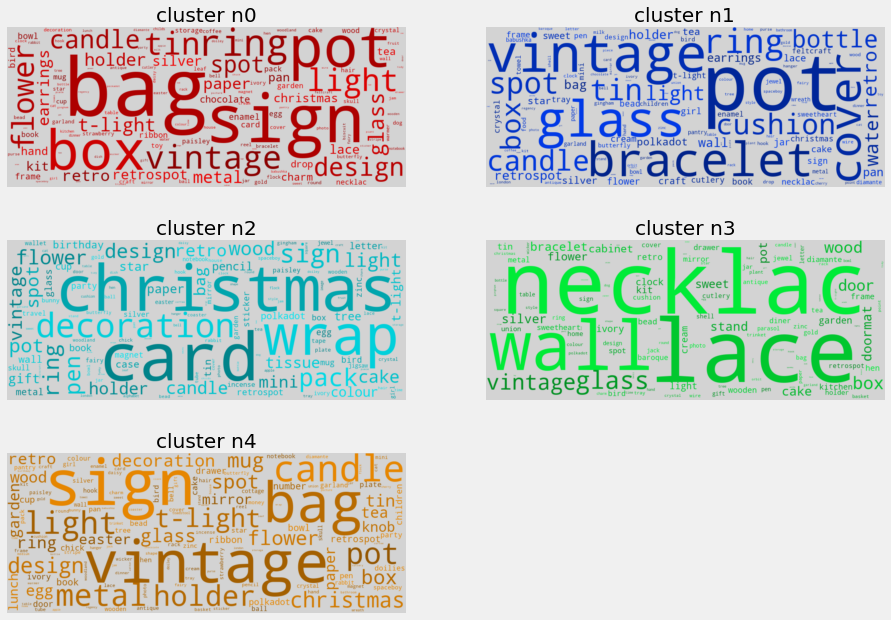

In [ ]:
fig = plt.figure(1, figsize=(14,14))
color = [0, 160, 130, 95, 280, 40, 330, 110, 25]
for i in range(n_clusters):
    list_cluster_occurences = occurance[i]
    tone = color[i]
    liste = []
    for key, value in list_cluster_occurences.items():
        liste.append([key, value])
    liste.sort(key = lambda x:x[1], reverse = True)
    make_wordcloud(liste, i+1)

>>1. Words like 'box', 'pot' are common in all clusters.
>>2. Cluster 3 has all luxury items.

###Dimensionality Reduction using PCA

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA()
pca.fit(matrix)
pca_samples = pca.transform(matrix)

>Amount of explained variance check

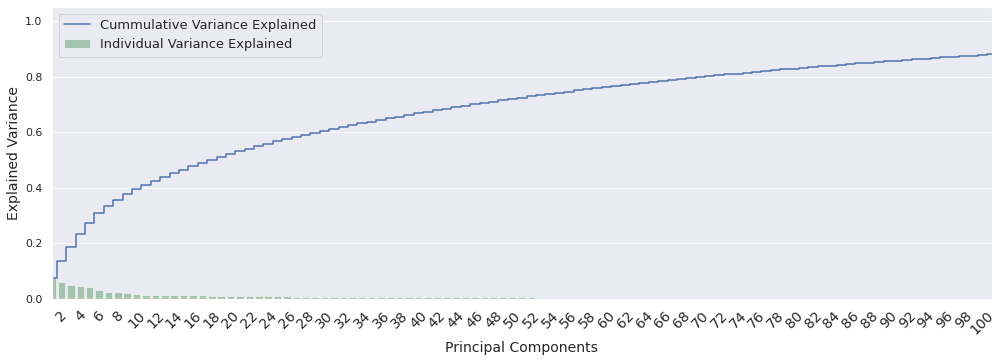

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.set(font_scale=1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where = 'mid', label = 'Cummulative Variance Explained')
sns.barplot(np.arange(1, matrix.shape[1] + 1), pca.explained_variance_ratio_, alpha = 0.5, color = 'g',
            label = 'Individual Variance Explained')
plt.xlim(0, 100)
plt.xticks(rotation = 45, fontsize = 14)
ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel("Explained Variance", fontsize = 14)
plt.xlabel("Principal Components", fontsize = 14)
plt.legend(loc = 'upper left', fontsize = 13)
plt.show()

More than 100 Principal Components are needed to explain more than 90 % of the variance.

###Customer Segments generation

Using present product categories and creating new feature for knowing which category product belongs.

In [ ]:
corresp = dict()
for key, val in zip(lists_products, clusters):
    corresp[key] = val
    
clean_df['categ_product'] = clean_df.loc[:, 'Description'].map(corresp)
clean_df[['InvoiceNo', 'Description', 'categ_product']][:10]

,InvoiceNo,Description,categ_product
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,0
1,536365,WHITE METAL LANTERN,1
2,536365,CREAM CUPID HEARTS COAT HANGER,1
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,1
4,536365,RED WOOLLY HOTTIE WHITE HEART.,1
5,536365,SET 7 BABUSHKA NESTING BOXES,3
6,536365,GLASS STAR FROSTED T-LIGHT HOLDER,1
7,536366,HAND WARMER UNION JACK,0
8,536366,HAND WARMER RED POLKA DOT,4
9,536367,ASSORTED COLOUR BIRD ORNAMENT,4


In [ ]:
for i in range(5):
    col = 'categ_{}'.format(i)
    df_temp = clean_df[clean_df['categ_product'] == i]
    price_temp = df_temp['UnitPrice'] * (df_temp['Quantity'] - df_temp['QuantityCancelled'])
    price_temp = price_temp.apply(lambda x:x if x > 0 else 0)
    clean_df.loc[:, col] = price_temp
    clean_df[col].fillna(0, inplace = True)
    
clean_df[['InvoiceNo', 'Description', 'categ_product', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4']][:10]

,InvoiceNo,Description,categ_product,categ_0,categ_1,categ_2,categ_3,categ_4
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,0,15.3,0.00,0.0,0.0,0.00
1,536365,WHITE METAL LANTERN,1,0.0,20.34,0.0,0.0,0.00
2,536365,CREAM CUPID HEARTS COAT HANGER,1,0.0,22.00,0.0,0.0,0.00
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,1,0.0,20.34,0.0,0.0,0.00
4,536365,RED WOOLLY HOTTIE WHITE HEART.,1,0.0,20.34,0.0,0.0,0.00
5,536365,SET 7 BABUSHKA NESTING BOXES,3,0.0,0.00,0.0,15.3,0.00
6,536365,GLASS STAR FROSTED T-LIGHT HOLDER,1,0.0,25.50,0.0,0.0,0.00
7,536366,HAND WARMER UNION JACK,0,11.1,0.00,0.0,0.0,0.00
8,536366,HAND WARMER RED POLKA DOT,4,0.0,0.00,0.0,0.0,11.10
9,536367,ASSORTED COLOUR BIRD ORNAMENT,4,0.0,0.00,0.0,0.0,54.08


In [ ]:
temp = clean_df.groupby(by=['CustomerID', 'InvoiceNo'], as_index = False)['TotalPrice'].sum()
basket_price = temp.rename(columns={'TotalPrice': 'Basket Price'})

for i in range(5):
    col = "categ_{}".format(i)
    temp = clean_df.groupby(by=['CustomerID', 'InvoiceNo'], as_index = False)[col].sum()
    basket_price.loc[:, col] = temp

clean_df['InvoiceDate_int'] = clean_df['InvoiceDate'].astype('int64')
temp = clean_df.groupby(by=['CustomerID', 'InvoiceNo'], as_index = False)['InvoiceDate_int'].mean()
clean_df.drop('InvoiceDate_int', axis = 1, inplace=True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])

basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID', ascending=True)[:5]

,CustomerID,InvoiceNo,Basket Price,categ_0,categ_1,categ_2,categ_3,categ_4,InvoiceDate
2,12347.0,537626,711.79,83.40,293.35,23.40,124.44,187.2,2010-12-07 14:57:00.000001024
3,12347.0,542237,475.39,53.10,169.20,84.34,38.25,130.5,2011-01-26 14:29:59.999999744
4,12347.0,549222,636.25,71.10,115.00,81.00,38.25,330.9,2011-04-07 10:42:59.999999232
5,12347.0,556201,382.52,78.06,168.76,41.40,19.90,74.4,2011-06-09 13:01:00.000000256
6,12347.0,562032,584.91,119.70,158.16,61.30,136.05,109.7,2011-08-02 08:48:00.000000000


In [ ]:
basket_price['InvoiceDate'].min()

Timestamp('2010-12-01 08:26:00')

In [ ]:
basket_price['InvoiceDate'].max()

Timestamp('2011-12-09 12:50:00')

>Splitting based on time

In [ ]:
import datetime
set_entrainement = basket_price[basket_price['InvoiceDate'] < datetime.datetime(2011,10,1)]
set_test = basket_price[basket_price['InvoiceDate'] >= datetime.datetime(2011, 9, 1)]
basket_price = set_entrainment.copy(deep = True)

>Grouping orders

In [ ]:
transanctions_per_user = basket_price.groupby(by=['CustomerID'])['Basket Price'].agg(['count', 'min', 'max', 'mean', 'sum'])

for i in range(5):
    col = 'categ_{}'.format(i)
    transanctions_per_user.loc[:, col] = basket_price.groupby(by=['CustomerID'])[col].sum() / transanctions_per_user['sum'] * 100
    
transanctions_per_user.reset_index(drop = False, inplace = True)
basket_price.groupby(by=['CustomerID'])['categ_0'].sum()
transanctions_per_user.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4
0,12347.0,5,382.52,711.79,558.172000,2790.86,14.524555,32.408290,10.442659,12.787815,29.836681
1,12348.0,4,227.44,892.80,449.310000,1797.24,0.000000,0.000000,38.016069,20.030714,41.953217
2,12350.0,1,334.40,334.40,334.400000,334.40,27.900718,0.000000,11.692584,11.961722,48.444976
3,12352.0,6,144.35,840.30,345.663333,2073.98,3.370331,15.711338,0.491808,67.534402,12.892120
4,12353.0,1,89.00,89.00,89.000000,89.00,19.887640,0.000000,0.000000,67.078652,13.033708


>Creating variables days since first purchase and days since last purchase

In [ ]:
last_date = basket_price['InvoiceDate'].max().date()

first_registration = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].min())
last_purchase = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].max())

test = first_registration.applymap(lambda x:(last_date - x.date()).days)
test2 = last_purchase.applymap(lambda x:(last_date - x.date()).days)

transanctions_per_user.loc[:, 'LastPurchase'] = test2.reset_index(drop = False)['InvoiceDate']
transanctions_per_user.loc[:, 'FirstPurchase'] = test.reset_index(drop = False)['InvoiceDate']

In [ ]:
transanctions_per_user[:3]

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,LastPurchase,FirstPurchase
0,12347.0,5,382.52,711.79,558.172,2790.86,14.524555,32.40829,10.442659,12.787815,29.836681,59,297
1,12348.0,4,227.44,892.80,449.310,1797.24,0.000000,0.00000,38.016069,20.030714,41.953217,5,288
2,12350.0,1,334.40,334.40,334.400,334.40,27.900718,0.00000,11.692584,11.961722,48.444976,240,240


>Customers making only one order

In [ ]:
n1 = transanctions_per_user[transanctions_per_user['count'] == 1].shape[0]
n2 = transanctions_per_user.shape[0]
print("No. of Customers with single purchase : {:<2}/{:<5} ({:<2.2f}%)".format(n1, n2, n1/n2*100))

No. of Customers with single purchase : 1446/3608  (40.08%)


####Making customer segments

In [ ]:
list_cols = ['count', 'min', 'max', 'mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4']
selected_customers = transanctions_per_user.copy(deep=True)
matrix = selected_customers[list_cols].to_numpy()

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(matrix)
print("Variable Mean Values: \n" + 90*'-' + '\n', scaler.mean_)
scaled_matrix = scaler.transform(matrix)

Variable Mean Values: 
------------------------------------------------------------------------------------------
 [  3.61973392 259.53323226 554.09032511 376.38353112  21.13434862
  16.38096333  13.9783833   23.20157049  25.31361084]


In [ ]:
pca = PCA()
pca.fit(scaled_matrix)
pca_samples = pca.transform(scaled_matrix)

>Again checking for variance explained

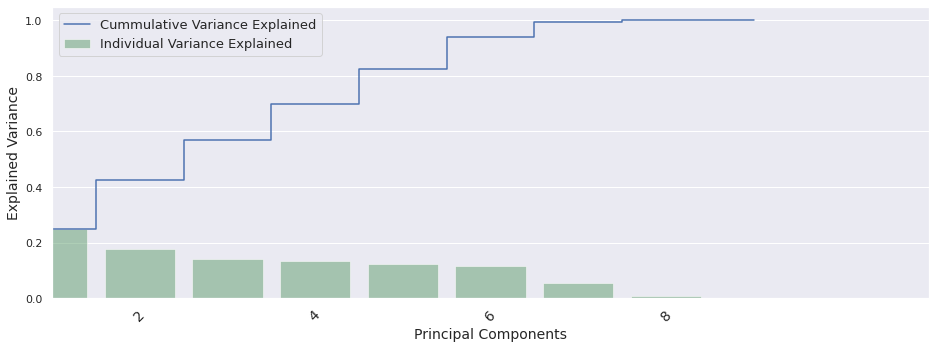

In [ ]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where = 'mid', label = 'Cummulative Variance Explained')
sns.barplot(np.arange(1, matrix.shape[1] + 1), pca.explained_variance_ratio_, alpha = 0.5, color = 'g',
            label = 'Individual Variance Explained')
plt.xlim(0, 10)
plt.xticks(rotation = 45, fontsize = 14)
ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel("Explained Variance", fontsize = 14)
plt.xlabel("Principal Components", fontsize = 14)
plt.legend(loc = 'upper left', fontsize = 13)
plt.show()

>Hyperparameter Tuning

In [ ]:
for n_clusters in range(3, 21):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init = 30)
    kmeans.fit(scaled_matrix)
    clusters = kmeans.predict(scaled_matrix)
    sil_avg = silhouette_score(scaled_matrix, clusters)
    print("For n_clusters : ", n_clusters, "The average silhouette_score is : ", sil_avg)

For n_clusters :  3 The average silhouette_score is :  0.15972259881267195
For n_clusters :  4 The average silhouette_score is :  0.15270225307527668
For n_clusters :  5 The average silhouette_score is :  0.1617818037491876
For n_clusters :  6 The average silhouette_score is :  0.17852684161082422
For n_clusters :  7 The average silhouette_score is :  0.1940619390902968
For n_clusters :  8 The average silhouette_score is :  0.20814575821520587
For n_clusters :  9 The average silhouette_score is :  0.2087712934207204
For n_clusters :  10 The average silhouette_score is :  0.2149539927402957
For n_clusters :  11 The average silhouette_score is :  0.21769851281740205
For n_clusters :  12 The average silhouette_score is :  0.18516148627027468
For n_clusters :  13 The average silhouette_score is :  0.1870210150606134
For n_clusters :  14 The average silhouette_score is :  0.18849125215782728
For n_clusters :  15 The average silhouette_score is :  0.18672220451373825
For n_clusters :  16 The

>Trying to improve silhouette_score by choosing 10 clusters

In [ ]:
n_clusters = 10
sil_avg = -1
while sil_avg < 0.208:
    kmeans = KMeans(init = 'k-means++', n_clusters = n_clusters, n_init = 30)
    kmeans.fit(scaled_matrix)
    clusters = kmeans.predict(scaled_matrix)
    sil_avg = silhouette_score(scaled_matrix, clusters)
    print("For n_clusters : ", n_clusters, "The average silhouette_score is : ", sil_avg)

For n_clusters :  10 The average silhouette_score is :  0.21378224176043367


In [ ]:
n_clusters = 10
kmeans = KMeans(init = 'k-means++', n_clusters = n_clusters, n_init = 100)
kmeans.fit(scaled_matrix)
clusters_clients = kmeans.predict(scaled_matrix)
silhouette_avg = silhouette_score(scaled_matrix, clusters_clients)
print("Silhouette Score : {:<.3f}".format(silhouette_avg))

Silhouette Score : 0.214


>Clusters:

In [ ]:
pd.DataFrame(pd.Series(clusters_clients).value_counts(), columns=['Number of Clients']).T

,3,9,7,5,6,1,2,0,4,8
Number of Clients,1502,536,436,317,309,262,201,22,12,11


>Further analysing clusters due to big difference in cluster segments

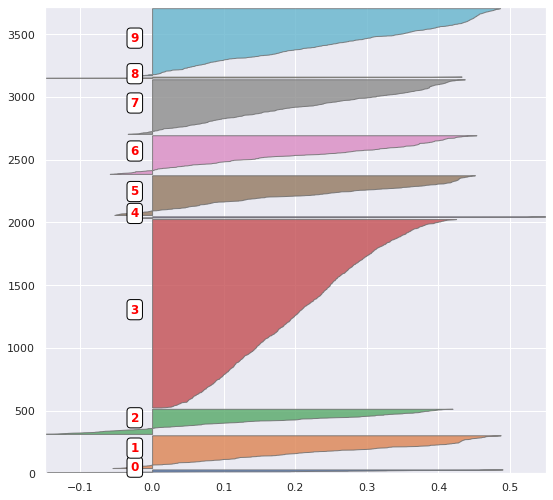

In [ ]:
sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)
graph_silhouette(n_clusters, [-0.15, 0.55], len(scaled_matrix), sample_silhouette_values, clusters_clients)

It's observed that the clusters are disjoint

Finding patterns in customers purchases

In [ ]:
selected_customers.loc[:, 'cluster'] = clusters_clients

In [ ]:
merged_df = pd.DataFrame()
for i in range(n_clusters):
    test = pd.DataFrame(selected_customers[selected_customers['cluster'] == i].mean())
    test = test.T.set_index('cluster', drop = True)
    test['size'] = selected_customers[selected_customers['cluster'] == i].shape[0]
    merged_df = pd.concat([merged_df, test])
    
merged_df.drop('CustomerID', axis = 1, inplace = True)
print('Number of customers : ', merged_df['size'].sum())

merged_df = merged_df.sort_values('sum')

Number of customers :  3608


>Reorganising dataset

In [ ]:
list_index = []
for i in range(5):
    column = 'categ_{}'.format(i)
    list_index.append(merged_df[merged_df[column] > 45].index.values[0])
    
list_index_reordered = list_index
list_index_reordered += [s for s in merged_df.index if s not in list_index]

merged_df = merged_df.reindex(index = list_index_reordered)
merged_df = merged_df.reset_index(drop = False)
merged_df.head()

,index,cluster,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,LastPurchase,FirstPurchase,size
0,0,5.0,2.958991,202.840662,403.695331,294.001500,1018.831861,59.563538,7.381220,7.107175,10.649154,15.298913,103.003155,198.640379,317
1,1,6.0,2.119741,204.560227,348.449126,265.195899,674.716408,13.878809,50.440506,6.569639,15.644578,13.516595,109.744337,168.174757,309
2,2,1.0,2.244275,191.553168,318.147939,247.309701,590.189924,11.336394,6.372769,55.007410,7.404388,19.880614,96.396947,166.893130,262
3,3,9.0,2.710821,200.719890,347.833265,261.772024,742.217465,11.295195,11.350093,4.945592,61.232418,11.187230,115.324627,187.800373,536
4,4,7.0,2.426606,212.795252,324.963626,266.176592,683.648007,12.581525,7.671654,11.861035,9.617869,58.271330,105.213303,174.396789,436


Saving the data of selected customers

In [ ]:
selected_customers.to_csv("selected_customers.csv")

In [ ]:
merged_df.to_csv("merged_df.csv")

###Classification of customers

In [ ]:
selected_customers = pd.read_csv('selected_customers.csv')
merged_df = pd.read_csv('merged_df.csv')

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
class Class_Fit(object):
    def __init__(self, clf, params = None):
        if params:
            self.clf = clf(**params)
        else:
            self.clf = clf()
            
    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)
    
    def predict(self, x):
        return self.clf.predict(x)
    
    def grid_search(self, parameters, Kfold):
        self.grid = GridSearchCV(estimator = self.clf, param_grid = parameters, cv = Kfold)
        
    def grid_fit(self, X, Y):
        self.grid.fit(X, Y)
        
    def grid_predict(self, X, Y):
        self.predictions = self.grid.predict(X)
        print("Precision: {:.2f} %".format(100 * accuracy_score(Y, self.predictions)))

In [ ]:
selected_customers.head()

,Unnamed: 0,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,LastPurchase,FirstPurchase,cluster
0,0,12347.0,5,382.52,711.79,558.172000,2790.86,14.524555,32.408290,10.442659,12.787815,29.836681,59,297,3
1,1,12348.0,4,227.44,892.80,449.310000,1797.24,0.000000,0.000000,38.016069,20.030714,41.953217,5,288,1
2,2,12350.0,1,334.40,334.40,334.400000,334.40,27.900718,0.000000,11.692584,11.961722,48.444976,240,240,7
3,3,12352.0,6,144.35,840.30,345.663333,2073.98,3.370331,15.711338,0.491808,67.534402,12.892120,2,226,9
4,4,12353.0,1,89.00,89.00,89.000000,89.00,19.887640,0.000000,0.000000,67.078652,13.033708,134,134,9


In [ ]:
columns = ['mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4']
X = selected_customers[columns]
Y = selected_customers['cluster']

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8)

###Training

In [ ]:
from sklearn.svm import LinearSVC
from warnings import filterwarnings
filterwarnings('ignore')

In [ ]:
svc = Class_Fit(clf=LinearSVC)
svc.grid_search(parameters = [{'C':np.logspace(-2,2,10)}], Kfold = 5)

In [ ]:
svc.grid_fit(X=X_train, Y=Y_train)

In [ ]:
svc.grid_predict(X_test, Y_test)

Precision: 83.93 %


In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[  0   0   0   7   0   0   0   0   0   0]
 [  0  46   0   4   0   0   0   0   0   0]
 [  0   0   0  35   0   0   0   0   0   1]
 [  0   0   0 301   0   0   0   0   0   0]
 [  0   0   0   1   0   0   0   0   0   0]
 [  0   0   0   9   0  51   0   0   0   0]
 [  0   0   0  16   0   0  53   0   0   0]
 [  0   0   0  24   0   0   0  69   0   0]
 [  0   0   0   3   0   0   0   0   0   0]
 [  0   0   0  16   0   0   0   0   0  86]]


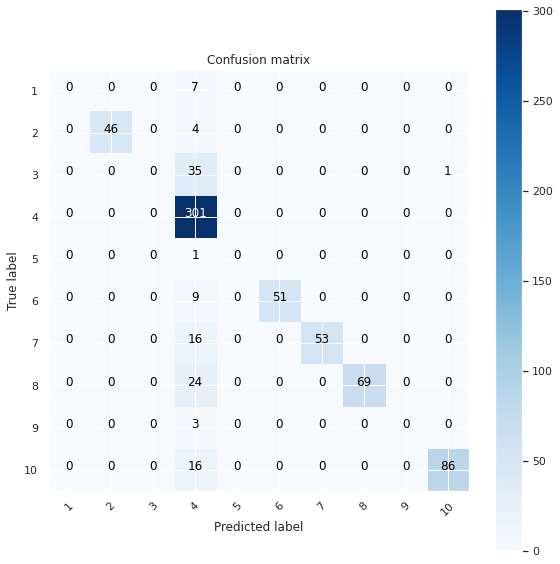

In [ ]:
class_names = [i for i in range(1,11)]
cnf = confusion_matrix(Y_test, svc.predictions)
np.set_printoptions(precision=2)
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf, class_names)

In [ ]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from warnings import filterwarnings
filterwarnings('ignore')
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

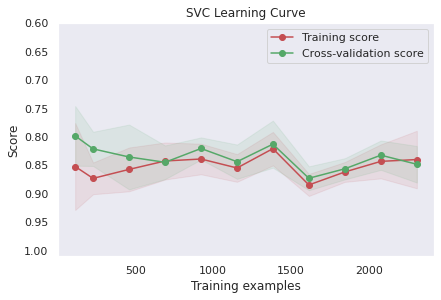

In [ ]:
g = plot_learning_curve(svc.grid.best_estimator_, "SVC Learning Curve", X_train, Y_train, ylim=[1.01, 0.6], cv = 5,
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

####Logistic regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from warnings import filterwarnings
filterwarnings('ignore')

In [ ]:
lr = Class_Fit(clf = LogisticRegression)
lr.grid_search(parameters = [{'C':np.logspace(-1,2,10)}], Kfold = 5)
lr.grid_fit(X_train, Y_train)
lr.grid_predict(X_test, Y_test)

Precision: 94.18 %


Confusion matrix, without normalization
[[  0   0   1   4   0   0   1   0   0   1]
 [  0  48   0   1   0   0   0   0   0   1]
 [  0   0  33   2   0   0   0   1   0   0]
 [  0   1   3 287   0   3   7   0   0   0]
 [  0   0   0   0   0   0   0   0   1   0]
 [  0   0   2   0   0  58   0   0   0   0]
 [  0   0   1   2   0   0  66   0   0   0]
 [  0   0   0   5   0   0   0  88   0   0]
 [  0   0   1   0   2   0   0   0   0   0]
 [  0   0   0   2   0   0   0   0   0 100]]


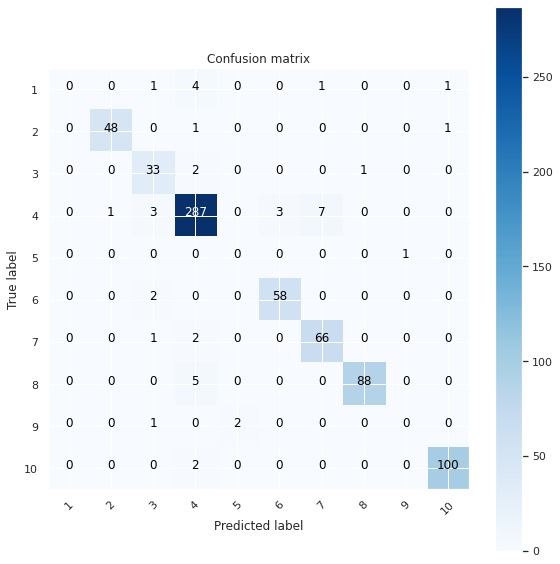

In [ ]:
cnf = confusion_matrix(Y_test, lr.predictions)
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf, class_names)

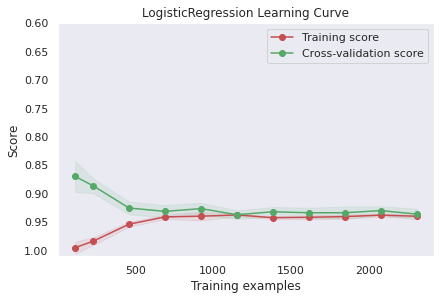

In [ ]:
g = plot_learning_curve(lr.grid.best_estimator_, "LogisticRegression Learning Curve", X_train, Y_train, ylim=[1.01, 0.6], cv = 5,
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

####KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
knn = Class_Fit(clf = KNeighborsClassifier)
knn.grid_search(parameters = [{'n_neighbors':np.arange(1,50,1)}], Kfold = 5)
knn.grid_fit(X_train, Y_train)
knn.grid_predict(X_test, Y_test)

Precision: 82.96 %


Confusion matrix, without normalization
[[  0   0   1   5   0   0   0   0   0   1]
 [  0  45   1   4   0   0   0   0   0   0]
 [  3   0  28   5   0   0   0   0   0   0]
 [  0   2   6 282   0   3   1   3   0   4]
 [  0   0   0   0   1   0   0   0   0   0]
 [  1   1   4  11   0  41   0   1   0   1]
 [  0   0   1  19   0   0  47   0   0   2]
 [  0   0   0  28   0   0   0  65   0   0]
 [  0   0   1   0   1   0   0   0   1   0]
 [  1   0   0  12   0   0   0   0   0  89]]


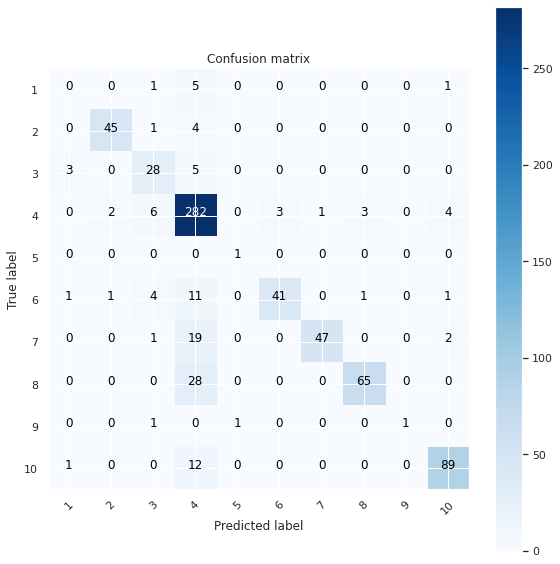

In [ ]:
cnf = confusion_matrix(Y_test, knn.predictions)
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf, class_names)

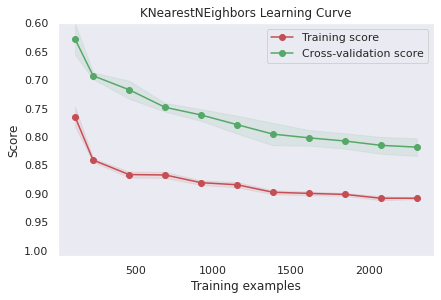

In [ ]:
g = plot_learning_curve(knn.grid.best_estimator_, "KNearestNEighbors Learning Curve", X_train, Y_train, ylim=[1.01, 0.6], cv = 5,
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

####Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
tr = Class_Fit(clf = DecisionTreeClassifier)
tr.grid_search(parameters = [{'criterion':['entropy', 'gini'], 'max_features':['sqrt', 'log2']}], Kfold = 5)
tr.grid_fit(X_train, Y_train)
tr.grid_predict(X_test, Y_test)

Precision: 88.50 %


Confusion matrix, without normalization
[[  0   0   1   4   0   0   1   0   0   1]
 [  0  46   0   3   0   0   0   0   0   1]
 [  0   1  23   8   0   1   1   2   0   0]
 [  5   3   7 278   0   3   3   0   0   2]
 [  0   0   0   0   0   0   1   0   0   0]
 [  0   2   1   2   0  54   0   1   0   0]
 [  3   1   0   4   2   0  58   0   0   1]
 [  0   0   0   6   0   0   0  87   0   0]
 [  0   0   3   0   0   0   0   0   0   0]
 [  0   1   1   2   1   0   2   2   0  93]]


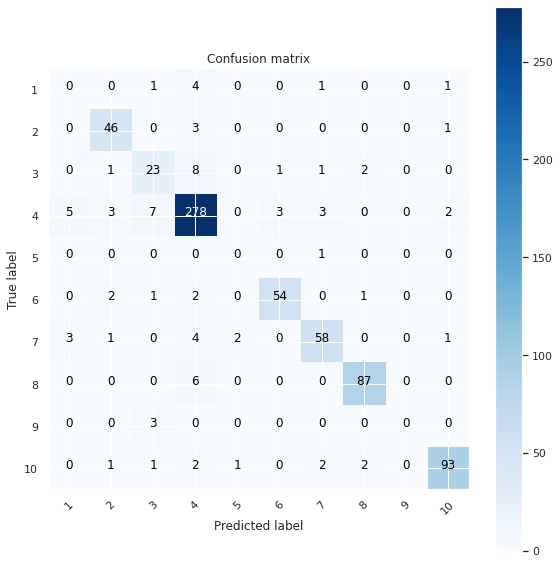

In [ ]:
cnf = confusion_matrix(Y_test, tr.predictions)
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf, class_names)

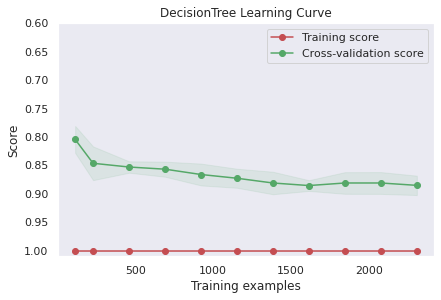

In [ ]:
g = plot_learning_curve(tr.grid.best_estimator_, "DecisionTree Learning Curve", X_train, Y_train, ylim=[1.01, 0.6], cv = 5,
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

####Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf = Class_Fit(clf = RandomForestClassifier)
rf.grid_search(parameters = [{'criterion':['entropy', 'gini'], 
                              'max_features':['sqrt', 'log2'], 'n_estimators':[20, 40, 60, 80, 100]}], Kfold = 5)
rf.grid_fit(X_train, Y_train)
rf.grid_predict(X_test, Y_test)

Precision: 92.80 %


Confusion matrix, without normalization
[[  0   0   1   4   0   0   1   0   0   1]
 [  0  49   0   1   0   0   0   0   0   0]
 [  0   1  31   2   0   1   1   0   0   0]
 [  0   1   7 287   0   2   4   0   0   0]
 [  0   0   0   0   0   0   1   0   0   0]
 [  0   1   2   1   0  55   0   0   0   1]
 [  0   0   1   5   0   0  62   1   0   0]
 [  0   0   0   6   0   0   0  87   0   0]
 [  0   0   1   0   1   1   0   0   0   0]
 [  0   0   0   1   0   0   2   0   0  99]]


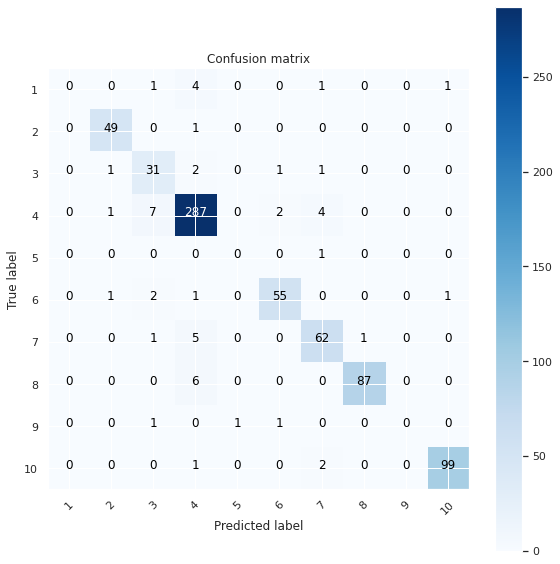

In [ ]:
cnf = confusion_matrix(Y_test, rf.predictions)
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf, class_names)

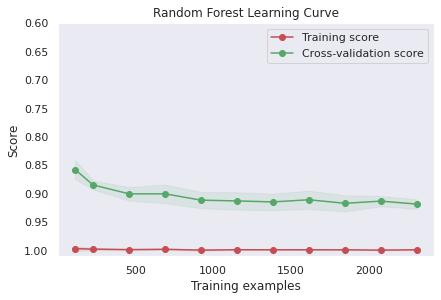

In [ ]:
g = plot_learning_curve(rf.grid.best_estimator_, "Random Forest Learning Curve", X_train, Y_train, ylim=[1.01, 0.6], cv = 5,
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

####AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

In [ ]:
ada = Class_Fit(clf = AdaBoostClassifier)
ada.grid_search(parameters = [{'n_estimators':[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}], Kfold = 5)
ada.grid_fit(X_train, Y_train)
ada.grid_predict(X_test, Y_test)

Precision: 55.54 %


Confusion matrix, without normalization
[[  0   0   0   6   0   0   0   0   0   1]
 [  0   0   0  50   0   0   0   0   0   0]
 [  0   0   0  31   1   0   0   0   1   3]
 [  0   0   0 301   0   0   0   0   0   0]
 [  0   0   0   0   1   0   0   0   0   0]
 [  0   0   0  59   0   0   0   0   0   1]
 [  0   0   0  68   0   0   0   0   0   1]
 [  0   0   0  92   0   0   0   0   0   1]
 [  0   0   0   0   3   0   0   0   0   0]
 [  0   0   0   3   0   0   0   0   0  99]]


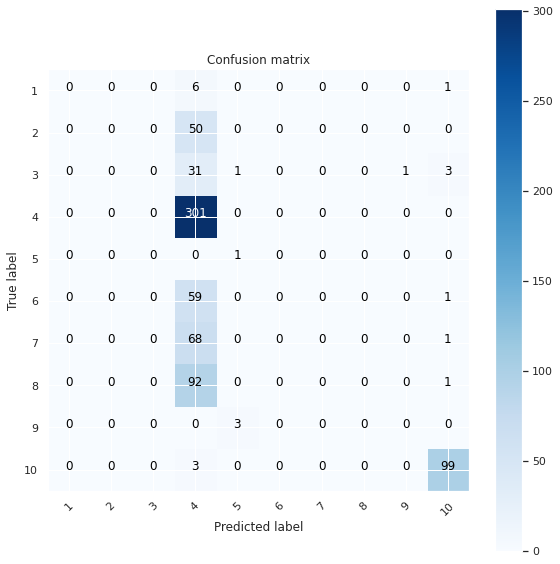

In [ ]:
cnf = confusion_matrix(Y_test, ada.predictions)
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf, class_names)

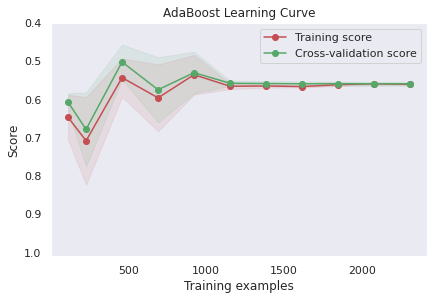

In [ ]:
g = plot_learning_curve(ada.grid.best_estimator_, "AdaBoost Learning Curve", X_train, Y_train, ylim=[1.01, 0.4], cv = 5,
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

####Gradient boost decision tree

In [ ]:
import xgboost

In [ ]:
gbdt = Class_Fit(clf = xgboost.XGBClassifier)
gbdt.grid_search(parameters = [{'n_estimators':[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}], Kfold = 5)
gbdt.grid_fit(X_train, Y_train)
gbdt.grid_predict(X_test, Y_test)

Precision: 92.66 %


Confusion matrix, without normalization
[[  0   0   1   4   0   0   1   0   0   1]
 [  0  48   0   1   0   0   0   1   0   0]
 [  0   1  31   3   0   0   1   0   0   0]
 [  0   1   7 284   0   3   4   1   0   1]
 [  0   0   0   0   0   0   0   0   1   0]
 [  0   1   3   1   0  55   0   0   0   0]
 [  0   0   1   5   0   0  63   0   0   0]
 [  0   0   0   6   0   0   0  87   0   0]
 [  0   0   2   0   1   0   0   0   0   0]
 [  0   0   0   1   0   0   0   0   0 101]]


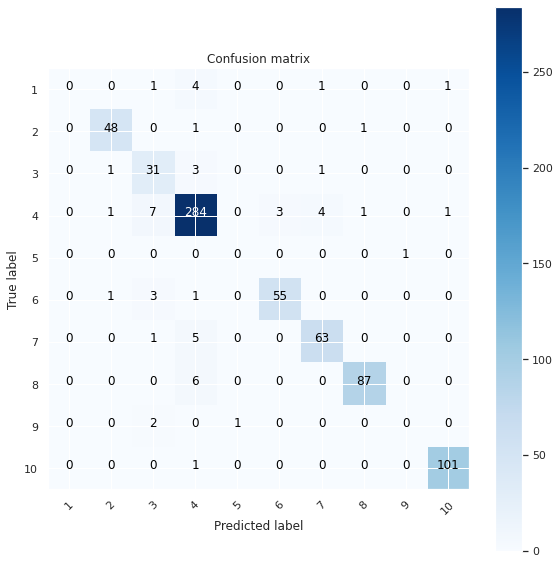

In [ ]:
cnf = confusion_matrix(Y_test, gbdt.predictions)
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf, class_names)

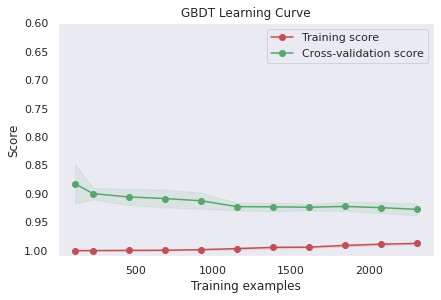

In [ ]:
g = plot_learning_curve(gbdt.grid.best_estimator_, "GBDT Learning Curve", X_train, Y_train, ylim=[1.01, 0.6], cv = 5,
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

####Deciding Classifier to use

In [ ]:
rf_best = RandomForestClassifier(**rf.grid.best_params_)
gbdt_best = xgboost.XGBClassifier(**gbdt.grid.best_params_)
svc_best = LinearSVC(**svc.grid.best_params_)
tr_best = DecisionTreeClassifier(**tr.grid.best_params_)
knn_best = KNeighborsClassifier(**knn.grid.best_params_)
lr_best = LogisticRegression(**lr.grid.best_params_)

In [ ]:
from sklearn.ensemble import VotingClassifier

In [ ]:
votingC = VotingClassifier(estimators=[('rf', rf_best), ('gb', gbdt_best), ('knn', knn_best), ('lr', lr_best)])
votingC = votingC.fit(X_train, Y_train)
predictions = votingC.predict(X_test)
print("Precision : {:.2f}%".format(100 * accuracy_score(Y_test, predictions)))

Precision : 93.21%


###Testing model

In [ ]:
basket_price = set_test.copy(deep=True)

In [ ]:
transanctions_per_user = basket_price.groupby(by=['CustomerID'])['Basket Price'].agg(['count', 'min', 'max', 'mean', 'sum'])
for i in range(5):
    col = 'categ_{}'.format(i)
    transanctions_per_user.loc[:, col] = basket_price.groupby(by=['CustomerID'])[col].sum() / transanctions_per_user['sum'] * 100
    
transanctions_per_user.reset_index(drop = False, inplace = True)
basket_price.groupby(by=['CustomerID'])['categ_0'].sum()

transanctions_per_user['count'] = 5 * transanctions_per_user['count']
transanctions_per_user['sum'] = transanctions_per_user['count'] * transanctions_per_user['mean']

transanctions_per_user.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4
0,12348.0,5,310.00,310.00,310.00,1550.00,0.000000,0.000000,0.000000,12.903226,87.096774
1,12352.0,10,266.25,366.25,316.25,3162.50,2.656126,38.363636,0.000000,42.869565,16.110672
2,12362.0,5,829.99,829.99,829.99,4149.95,23.837637,31.885926,3.426547,30.476271,10.373619
3,12364.0,5,79.80,79.80,79.80,399.00,0.000000,0.000000,81.203008,18.796992,0.000000
4,12372.0,5,383.12,383.12,383.12,1915.60,4.619962,8.352474,5.199415,7.830445,73.997703


In [ ]:
list_cols = ['count', 'min', 'max', 'mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4']
matrix_test = transanctions_per_user[list_cols].to_numpy()
scaled_test_matrix = scaler.transform(matrix_test)

In [ ]:
Y = kmeans.predict(scaled_test_matrix)
columns = ['mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4' ]
X = transanctions_per_user[columns]
predictions = votingC.predict(X)

In [ ]:
print("Precision : {:.2f}%".format(100 * accuracy_score(Y, predictions)))

Precision : 93.81%
